# Определение фотошопа гос. номера на фото автомобилей

### Дано: 
К вам пришёл бизнес с таким запросом:

Некоторые продавцы автомобилей на Авито учатся обходить проверку сервисом Fake Vin путём фотошопинга государственного регистрационного знака (ГРЗ), подставляя чужие номера на свой авто. 

#### Данные
- Авторы задачи принесли 20 примеров от тех. поддержки. 
- Для всех фотографий авто с Авито можно получить полигон ГРЗ.

#### Проблемы
Покупатели: 
- Приезжают на абсолютно другой автомобиль и могут не сверить VIN при покупке.
- Негативный опыт работы с платформой

Продавцы:
- Могут обойти проверку Fake Vin используя фотошоп
- Имеют возможность скрыть данные об автомобиле

Авито:
- Загрязнённая выдача, где покупатель не понимает, что за авто перед ним
- Испорченная репутация Авито и Автотеки

#### Требования

Необходимо разработать модель определения наличия фотошопа ГРЗ на изображении. Модель должна выдавать вероятность и классы. Смотрим на метрики `Precision` и `Recall`.

![Пример](../data/assets/photoshop_example.jpg)


# Задачи

#### 1. Анализ данных

1. Оценить потенциальное количество фотошопленных картинок в данных Авито.
2. Оценить стоимость разметки для получения необходимого количества примеров для обучения.

#### 2. Обучение

1. Сгенерировать синтетический датасет
2. Обучить модель, оценить качество на синтетике и реальных примерах
3. Отобрать данные для разметки

In [444]:
from typing import Union

import os
import copy
import numpy as np
import pandas as pd
import cv2
import timm
import torch
import albumentations as A
import requests as req
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import random
from collections import defaultdict

from ast import literal_eval
from IPython.display import display
from pathlib import Path
from albumentations.pytorch import ToTensorV2
from tqdm.autonotebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

## 1. Анализ данных

In [487]:
df = pd.read_csv('../data/dataset/images_info.csv')
df['image_path'] = ''
print(len(df))
df.head(3)

42325


item_ext_id  image_ext_id  original_image_ids  imageType  imageTypeProb  \
0   1738513683   11054410415         11054402639        1.0          0.997   
1   1745165273   11051401806         11051299938        1.0          1.000   
2   1903018708    8739758535          8739748528        1.0          0.994   

  plateNumber  plateNumberProb  \
0    н318ув22             0.93   
1   е651ре163             0.76   
2          ет             0.00   

                                        platePolygon  plateAngle  \
0  [0.17625, 0.67076, 0.29323, 0.67111, 0.2937, 0...         0.0   
1  [0.05592, 0.51576, 0.13286, 0.54542, 0.1307, 0...         0.0   
2  [0.38523, 0.52589, 0.57534, 0.54204, 0.57682, ...         0.0   

   plateAngleProb  plateType  plateTypeProb  \
0           1.000        1.0          1.000   
1           1.000        1.0          1.000   
2           0.999        7.0          0.998   

                                        url_1280x960 image_path  \
0  https://30.img.avito.st/image/1/1.kjShwraxPt2X...              
1  https://30.img.avito.st/image/1/1.v3laO7axE5Bs...              
2  https://20.img.avito.st/image/1/1.bYsQnLaxwWIm...              

                                                meta  
0  {'model': '"SM-G955F"', 'make': '"samsung"', '...  
1  {'model': 'iPhone 6', 'make': 'Apple', 'create...  
2                                                NaN

Скачаем картинки и отрисуем полигоны номеров

In [4]:
async def download_image(session: aiohttp.ClientSession,
                         image_id: int,
                         url: str,
                         base_path: Path) -> (bool, str):
    """
    Скачивает одну картинку по заданному URL и сохраняет её по пути base_path/image_id.jpg.
    Возвращает кортеж (успех, image_id), где успех — bool, показывающий,
    удалось или нет скачать картинку.
    """
    out_path = base_path / f"{image_id}.jpg"

    try:
        async with session.get(url) as response:
            if response.status == 200:
                content = await response.read()
                with open(out_path, "wb") as f:
                    f.write(content)
                return True, image_id
            else:
                return False, image_id
    except Exception as e:
        return False, image_id

async def download_images_in_batches(df: pd.DataFrame,
                                     base_path: Union[Path, str],
                                     batch_size: int = 50) -> None:
    """
    Скачивает картинки ассинхронно батчами.
    
    :param df: DataFrame с колонками "image_id" и "url".
    :param base_path: Путь, по которому будут сохранены картинки.
    :param batch_size: Размер батча (количество запросов одновременно).
    """
    base_path = Path(base_path)
    base_path.mkdir(exist_ok=True, parents=True)

    failed_idx = []
    successful_idx = []
    total_batches = len(df) // batch_size + 1
    async with aiohttp.ClientSession() as session:
        pbar = tqdm(range(0, len(df), batch_size))
        for start_idx in pbar:
            end_idx = start_idx + batch_size
            chunk = df.iloc[start_idx:end_idx]
            tasks = [
                download_image(session, row["image_ext_id"], row["url_1280x960"], base_path)
                for _, row in chunk.iterrows()
            ]
            # results — список кортежей (успех: bool, image_id: str)
            results = await asyncio.gather(*tasks)
            # Добавляем image_id неуспешных скачиваний в общий список
            for (success, image_id), idx in zip(results, chunk.index):
                if not success:
                    failed_idx.append(idx)
                    df.loc[idx, 'image_path'] = ''
                else:
                    successful_idx.append(idx)
                    df.loc[idx, 'image_path'] = str(base_path / f"{image_id}.jpg")
            pbar.set_description(f"Total batches: {total_batches}, failed: {len(failed_idx)}, downloaded: {len(successful_idx)}")
        
    return successful_idx, failed_idx
        

In [6]:
successful_idx, failed_idx = await download_images_in_batches(df, '/app/data/dataset/images', 50)

Total batches: 847, failed: 82, downloaded: 42243: 100%|██████████| 847/847 [07:24<00:00,  1.90it/s]


In [10]:
new_successful_idx, really_failed_idx = await download_images_in_batches(df.iloc[failed_idx], '/app/data/dataset/images', 5)

Total batches: 17, failed: 81, downloaded: 1: 100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


In [15]:
df = df.drop(really_failed_idx)

In [490]:
df.head(3)

item_ext_id  image_ext_id  original_image_ids  imageType  imageTypeProb  \
0   1738513683   11054410415         11054402639        1.0          0.997   
1   1745165273   11051401806         11051299938        1.0          1.000   
2   1903018708    8739758535          8739748528        1.0          0.994   

  plateNumber  plateNumberProb  \
0    н318ув22             0.93   
1   е651ре163             0.76   
2          ет             0.00   

                                        platePolygon  plateAngle  \
0  [0.17625, 0.67076, 0.29323, 0.67111, 0.2937, 0...         0.0   
1  [0.05592, 0.51576, 0.13286, 0.54542, 0.1307, 0...         0.0   
2  [0.38523, 0.52589, 0.57534, 0.54204, 0.57682, ...         0.0   

   plateAngleProb  plateType  plateTypeProb  \
0           1.000        1.0          1.000   
1           1.000        1.0          1.000   
2           0.999        7.0          0.998   

                                        url_1280x960 image_path  \
0  https://30.img.avito.st/image/1/1.kjShwraxPt2X...              
1  https://30.img.avito.st/image/1/1.v3laO7axE5Bs...              
2  https://20.img.avito.st/image/1/1.bYsQnLaxwWIm...              

                                                meta  
0  {'model': '"SM-G955F"', 'make': '"samsung"', '...  
1  {'model': 'iPhone 6', 'make': 'Apple', 'create...  
2                                                NaN

In [499]:
df['image_path'] = df.apply(lambda x: str(Path('/app/data/dataset/images') / f'{x.image_ext_id}.jpg'), axis=1)

In [501]:
def drawpolygon(image: np.ndarray,
                polygonpoints: np.ndarray,
                color: tuple = (0, 255, 0),
                thickness: int = 2) -> np.ndarray:
    """
    Рисует полигон на изображении.

    :param image: Изображение в формате numpy.ndarray (BGR, как в OpenCV).
    :param polygonpoints: Список/массив из 8 элементов (4 вершины x,y),
                          каждая координата - от 0.0 до 1.0.
                          Например: [[x1, y1], [x2, y2], [x3, y3], [x4, y4]].
    :param color: Цвет линий в формате (B, G, R).
    :param thickness: Толщина линий.
    :return: Исходное изображение с нарисованным полигоном.
    """
    # Размеры изображения
    h, w = image.shape[:2]
    # Преобразуем относительные координаты в абсолютные пиксельные
    polygonpoints = polygonpoints.copy()
    polygonpoints[:, 0] *= w - 1
    polygonpoints[:, 1] *= h - 1
    # Превращаем список точек в массив формата, подходящего для cv2.polylines
    polygonpoints = polygonpoints.astype(np.int32).reshape((-1, 1, 2))
    # Отрисовываем полигон
    cv2.polylines(image, [polygonpoints], isClosed=True, color=color, thickness=thickness)
    return image

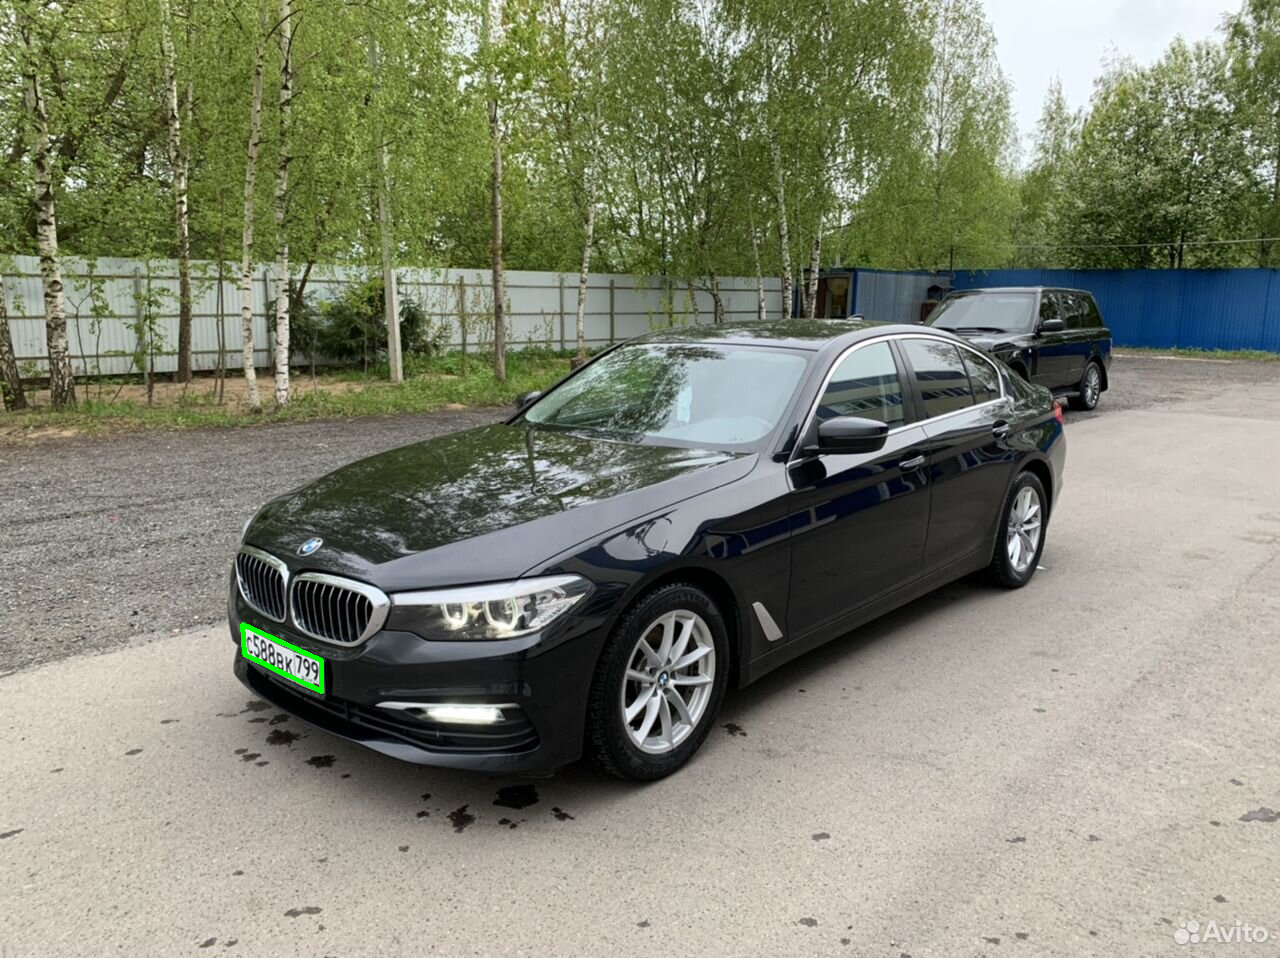

In [505]:
s = df.iloc[3]
img = cv2.imread(s.image_path, cv2.IMREAD_COLOR_RGB)
poly = np.array(literal_eval(s.platePolygon)).reshape((4, 2))
poly_img = drawpolygon(img, poly, thickness=4)
Image.fromarray(poly_img)

In [299]:
s.image_path

'/app/data/dataset/images/11051401806.jpg'

Посмотрим на "плохие" номера

<Axes: >

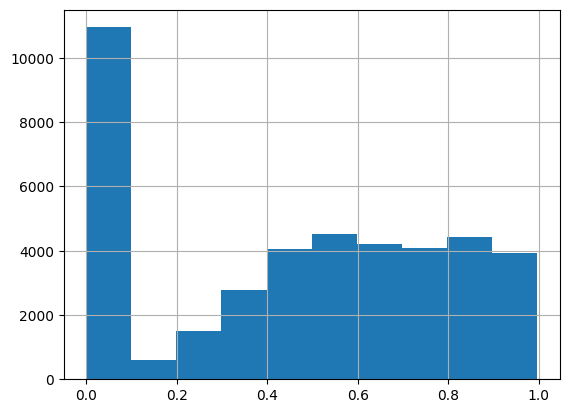

In [506]:
df.plateNumberProb.hist(bins=10)

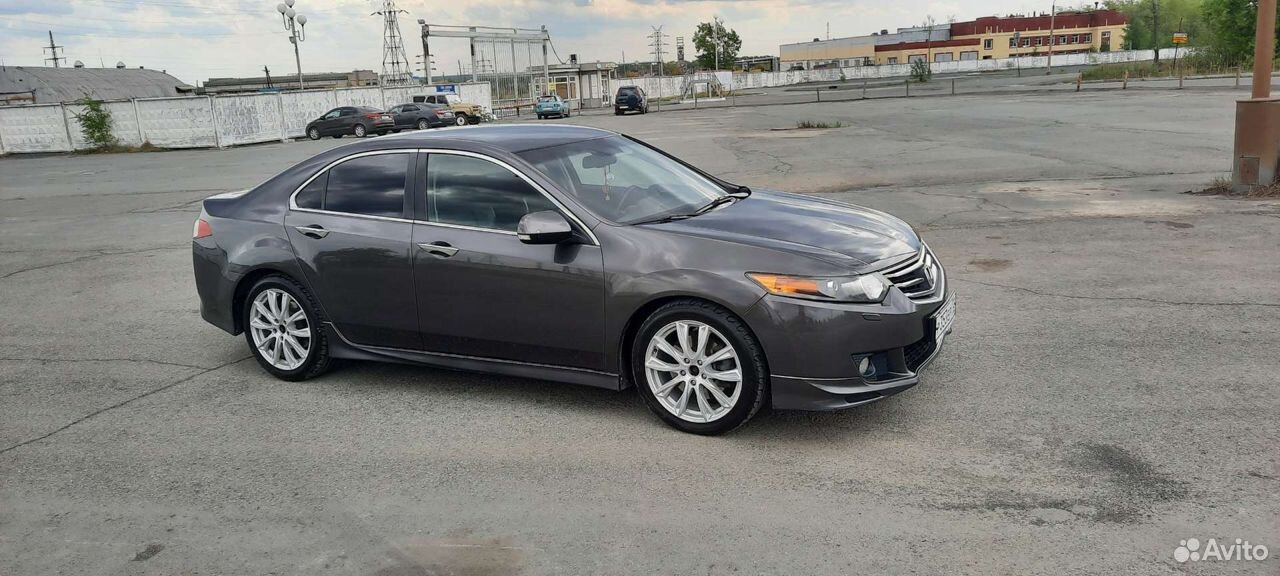

In [513]:
s = df[df.plateNumberProb < 0.1].sample(1)
img = cv2.imread(s.image_path.values[0], cv2.IMREAD_COLOR_RGB)
# poly = np.array(literal_eval(s.platePolygon)).reshape((4, 2))
# poly_img = drawpolygon(img, poly, thickness=4)
Image.fromarray(img)

Отсечём все картинки с вероятностью ниже 0.2

In [323]:
df = df[df.plateNumberProb > 0.2]
len(df)

29436

In [324]:
def crop_license_plate(image_path: str, 
                       poly_plate: str,  # '[x1, y1, x2, y2, x3, y3, x4, y4]'
                       alpha: float,
                       output_size: tuple = (100, 200)) -> np.ndarray:
    """
    Вырезает и выравнивает автомобильный номер по заданным координатам полигона,
    приводя к размеру outputsize (H, W).

    :param image_path: Путь к исходному изображению.
    :param poly_plate: Координаты четырёхугольника номерного знака (x1, y1, x2, y2, x3, y3, x4, y4).
    :param alpha: Коэффициент, на который масштабируется исходная область полигона (1.0 = без изменений).
    :param output_size: Кортеж (H, W), к которому будет приведён номер.
    :return: Вырезанное и выровненное изображение номерного знака в формате NumPy массива.
    """

    # Шаг 1. Считать изображение
    image = cv2.imread(image_path)
    if image is None:
        print(f"Не удалось открыть файл: {image_path}")
        return None
    h, w, _ = image.shape
    # Шаг 2. Преобразовать polyPlate в массив numpy (4 точки)
    # Предполагаем, что точки даны в порядке (x1, y1), (x2, y2), (x3, y3), (x4, y4).
    try:
        src_points = np.array(literal_eval(poly_plate), dtype=np.float32).reshape(4, 2)
    except:
        return None
    src_points[:, 0] *= w
    src_points[:, 1] *= h 
    
    # Шаг 3. Найти центр (например, центр масс):
    center = np.mean(src_points, axis=0)  # [cx, cy]
    
    # Шаг 4. Линейно увеличить (или уменьшить) полигон вокруг центра
    # scaled_points = center + alpha*(src_points - center).
    # Если alpha = 1.0, ничего не меняется. Если alpha > 1.0, полигон увеличивается, если < 1.0 - уменьшается.
    scaled_points = center + alpha * (src_points - center)
    
    # Шаг 5. Определить целевые точки (куда «спроецировать» номер)
    # Порядок должен соответствовать порядку точек scaled_points
    H, W = output_size
    dst_points = np.array([
        [0,   0],
        [W-1, 0],
        [W-1, H-1],
        [0,   H-1]
    ], dtype=np.float32)

    # Шаг 6. Построить матрицу перспективного преобразования
    M = cv2.getPerspectiveTransform(scaled_points, dst_points)

    # Шаг 7. Применить перспективное преобразование (warpPerspective)
    warped_plate = cv2.warpPerspective(image, M, (W, H), flags=cv2.INTER_LINEAR)

    return warped_plate

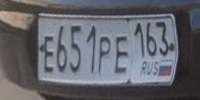

In [325]:
s = df.iloc[1]
wrapped = crop_license_plate(s.image_path, s.platePolygon, 1.5)
Image.fromarray(cv2.cvtColor(wrapped, cv2.COLOR_BGR2RGB))

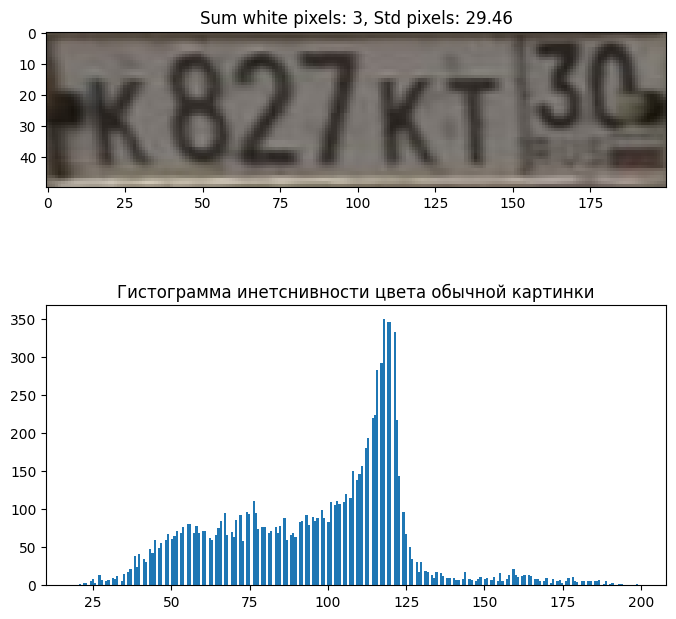

In [517]:
s = df.iloc[30]

fog, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
wrapped = crop_license_plate(s.image_path, s.platePolygon, 1.0, (50, 200))
gray = cv2.cvtColor(wrapped, cv2.COLOR_BGR2GRAY)
histogram, bin_edges = np.histogram(gray, bins=256)
sum_white_pixels = np.sum(histogram[250:])
std_plate_number = np.std(gray)
axes[0].set_title(f'Sum white pixels: {sum_white_pixels}, Std pixels: {std_plate_number:.2f}')
axes[0].imshow(cv2.cvtColor(wrapped, cv2.COLOR_BGR2RGB))
axes[1].hist(gray.flatten(), bins=256)
axes[1].set_title('Гистограмма инетснивности цвета обычной картинки')
plt.show()

Посмотрим на примеры фотошопа

In [521]:
ph = pd.read_csv('/app/data/dataset/photoshoped_downloaded.csv')
print(len(ph))
ph.head(3)

43


item_ext_id  image_ext_id  original_image_ids  \
0   2955743983   19279285460         19279192206   
1   4004426315   27175415698         27175411813   
2   2568029698   15097058206         15096924612   

                                                meta  \
0                                                NaN   
1                                                NaN   
2  {'model': None, 'make': None, 'created': None,...   

                                        platePolygon  plateNumberProb  \
0  [0.36319, 0.65999, 0.5871, 0.66115, 0.58798, 0...            0.281   
1  [0.41195, 0.72859, 0.61767, 0.72423, 0.61848, ...            0.945   
2  [0.82207, 0.65224, 0.92783, 0.57554, 0.92075, ...            0.579   

  plateNumber  imageType  imageTypeProb  plateAngle  plateAngleProb  \
0   к170ак798        1.0            1.0         0.0             1.0   
1    с044сс69        1.0            1.0         0.0             1.0   
2   е670ва750        1.0            1.0         0.0             1.0   

   plateType  plateTypeProb  \
0        1.0          0.998   
1        1.0          1.000   
2        1.0          1.000   

                                          image_path  label  
0  /app/data/dataset/photoshoped_images/192791922...    1.0  
1  /app/data/dataset/photoshoped_images/271754118...    1.0  
2  /app/data/dataset/photoshoped_images/150969246...    0.0

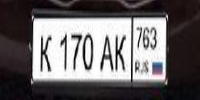

In [518]:
s = ph.iloc[0]
wrapped = crop_license_plate(s.image_path, s.platePolygon, 1.5)
Image.fromarray(cv2.cvtColor(wrapped, cv2.COLOR_BGR2RGB))

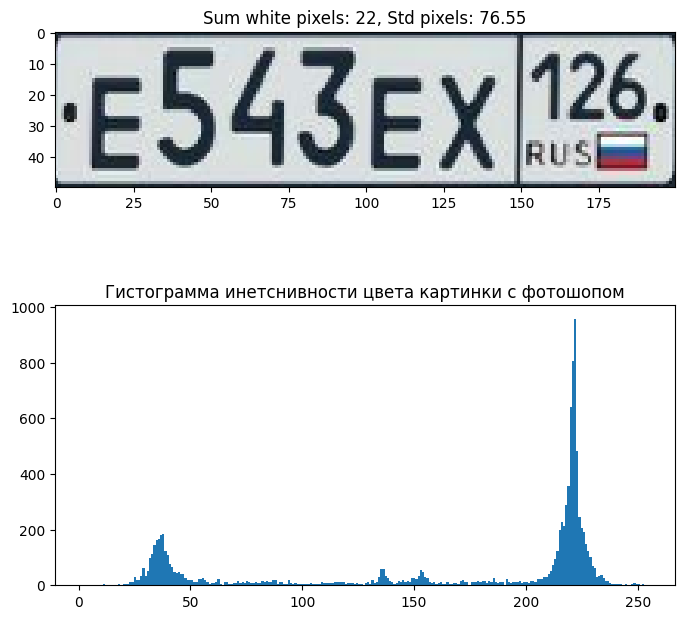

In [545]:
s = ph.iloc[21]

fog, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
wrapped = crop_license_plate(s.image_path, s.platePolygon, 1.0, (50, 200))
gray = cv2.cvtColor(wrapped, cv2.COLOR_BGR2GRAY)
histogram, bin_edges = np.histogram(gray, bins=256)
sum_white_pixels = np.sum(histogram[250:])
std_plate_number = np.std(gray)
axes[0].set_title(f'Sum white pixels: {sum_white_pixels}, Std pixels: {std_plate_number:.2f}')
axes[0].imshow(cv2.cvtColor(wrapped, cv2.COLOR_BGR2RGB))
axes[1].hist(gray.flatten(), bins=256)
axes[1].set_title('Гистограмма инетснивности цвета картинки с фотошопом')
plt.show()

### 1.1 Оценка количества картинок с фотошопом
Выглядит так, ка будто ест отличие по цвету, попробуем поймать его.

In [330]:
def crop_classic_features(row: pd.Series,
                          alpha: float = 1.0,
                          dst_size: tuple = (50, 200)):
    crop = crop_license_plate(row.image_path, row.platePolygon, alpha, dst_size)
    if crop is None:
        return [None, None]
    gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    # эвристика по числу "белых" ярких пикслей и std области номера
    histogram, bin_edges = np.histogram(gray_crop, bins=256)
    sum_white_pixels = np.sum(histogram[250:])
    std_plate_number = np.std(gray_crop)
    return [sum_white_pixels, std_plate_number]

In [331]:
ph_features = np.stack(ph.apply(crop_classic_features, axis=1).values)
ph['sum_white_pixels'] = ph_features[:, 0]
ph['std_plate_number'] = ph_features[:, 1]

In [332]:
df_features = np.stack(df.apply(crop_classic_features, axis=1).values)
df['sum_white_pixels'] = df_features[:, 0]
df['std_plate_number'] = df_features[:, 1]

Не удалось открыть файл: 


[ WARN:0@331805.664] global loadsave.cpp:268 findDecoder imread_(''): can't open/read file: check file path/integrity


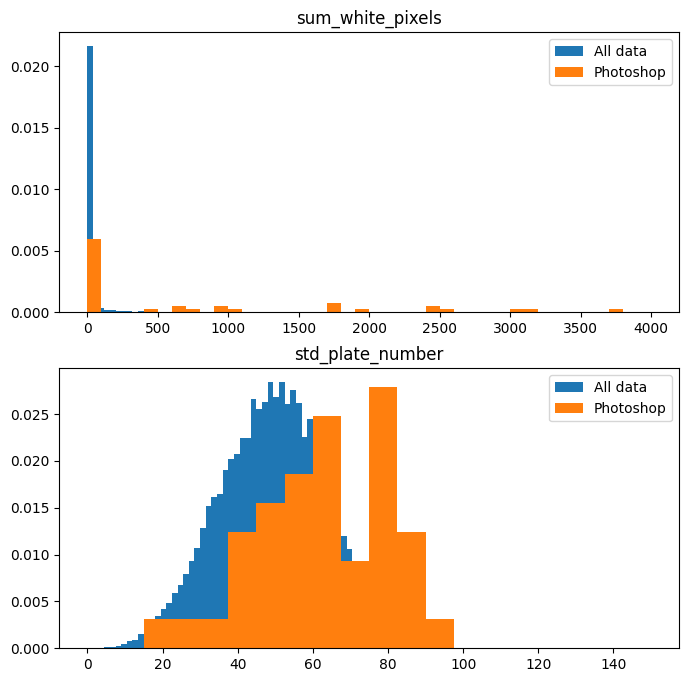

In [333]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
axes[0].hist(x=df['sum_white_pixels'].dropna().values, label='All data', bins=100, density=True, range=[0, 4000])
axes[0].hist(x=ph['sum_white_pixels'].dropna().values, label='Photoshop', bins=40, density=True, range=[0, 4000])
axes[0].legend()
axes[0].set_title('sum_white_pixels')
axes[1].hist(x=df['std_plate_number'].dropna().values, label='All data', bins=100, density=True, range=[0, 150])
axes[1].hist(x=ph['std_plate_number'].dropna().values, label='Photoshop', bins=20, density=True, range=[0, 150])
axes[1].legend()
axes[1].set_title('std_plate_number')
plt.show()

In [334]:
sum_white_pixels_threshold = 500
std_plate_number_threshold = 80

print(f'Photoshop sum_white_pixels > thr: {sum(ph.sum_white_pixels > sum_white_pixels_threshold)/len(ph)*100:.1f}')
print(f'Photoshop std_plate_number > thr: {sum(ph.std_plate_number > std_plate_number_threshold)/len(ph)*100:.1f}')

print(f'All data sum_white_pixels > thr: {sum(df.sum_white_pixels > sum_white_pixels_threshold)/len(df)*100:.1f}')
print(f'All data std_plate_number > thr: {sum(df.std_plate_number > std_plate_number_threshold)/len(df)*100:.1f}')

Photoshop sum_white_pixels > thr: 39.5
Photoshop std_plate_number > thr: 14.0
All data sum_white_pixels > thr: 5.8
All data std_plate_number > thr: 0.7


In [335]:
sum_white_pixels_threshold = 500
std_plate_number_threshold = 80
ph_ft_count = sum((ph.sum_white_pixels > sum_white_pixels_threshold) & \
                 (ph.std_plate_number > std_plate_number_threshold))
df_ft_count = sum((df.sum_white_pixels > sum_white_pixels_threshold) & \
                 (df.std_plate_number > std_plate_number_threshold))
print(f'Photoshop sum_white_pixels > thr & std_plate_number > thr: {ph_ft_count/len(ph)*100:.1f}')
print(f'All data sum_white_pixels > thr & std_plate_number > thr: {df_ft_count/len(df)*100:.1f}')

Photoshop sum_white_pixels > thr & std_plate_number > thr: 14.0
All data sum_white_pixels > thr & std_plate_number > thr: 0.3


### 1.2 Оценка разметки
Допустим, мы хотим 5000 примеров фотошопленных картинок. Оценим долю явно фотошопленных картинок в общей совокупности в 0.3-2.1% от общего множества картинок. Тогда при цене разметки в 1 рубль за картинку стоимость разметки выйдет нам от 240 тыс. до 1.7 млн рублей. Звучит довольно внушительно, так что давайте попробуем отобрать картинки.

## 2. Обучение
Сгенерируем синтетический датасет фотошопленных фото:

1. Сгенерируем плашки номеров
2. Наложим их на картинки из общей выборки

### 2.1 Генерация

Посмотрим на код генерации в `plate_gen`.

Возьмём базовые рамки российских номеров:

![Раз](../plate_gen/assets/rus_white_long_lp_v2.png)
![Два](../plate_gen/assets/rus_white_long_lp.png)
![Три](../plate_gen/assets/rus_white_lp.png)
![Четыре](../plate_gen/assets/rus_white_short_lp.png)

Добавим на них буквы из алфавита (ABCEOHKMPTXY) и цифры (0123456789):

![Раз](../data/dataset/synt_plates_basic_10k/A001MT196.jpg)
![Два](../data/dataset/synt_plates_basic_10k/A398KA255.jpg)
![Три](../data/dataset/synt_plates_basic_10k/P525AO70.jpg)
![Четыре](../data/dataset/synt_plates_basic_10k/X816XA738.jpg)

Наложим получившиеся номерные рамки на фотографии автомобилей.

In [336]:
def adjust_contrast(image, alpha=1.5):
    """
    Повышает контраст изображения.
    Args:
        image (numpy.ndarray): Исходное изображение.
        alpha (float): Коэффициент контраста. >1 увеличивает контраст, <1 уменьшает.

    Returns:
        numpy.ndarray: Изображение с повышенным контрастом.
    """
    image_float = image.astype(np.float32)
    contrasted = cv2.convertScaleAbs(image_float, alpha=alpha, beta=0)
    return contrasted

def process_plate_polygon(plate_polygon, image_shape):
    """
    Масштабирует координаты полигона плашки на основе размеров изображения.
    Предполагается, что plate_polygon содержит 8 нормализованных координат (x1, y1, x2, y2, ..., x4, y4).
    """
    plate_polygon = np.array(plate_polygon).reshape((4, 2))
    scaled_polygon = plate_polygon * np.array([image_shape[1], image_shape[0]])
    return scaled_polygon

def overlay_generated_plate_and_save(car_image_path, gen_plate_image_path, polygon, output_path, 
                                    p=0.5, contrast_p=0.3, scale_p=0.3, scale_factor=1.2, perspective_intensity=0.5):
    """
    Накладывает сгенерированную плашку на изображение автомобиля и сохраняет результат.
    С вероятностью p перспективное преобразование применяется частично.
    С вероятностью contrast_p применяется повышение контраста.
    С вероятностью scale_p применяется масштабирование плашки на scale_factor раз.
    Степень применения перспективы регулируется параметром perspective_intensity.

    Args:
        car_image_path (str): Путь к изображению автомобиля.
        gen_plate_image_path (str): Путь к сгенерированной плашке.
        polygon (list or np.array): Координаты полигона плашки (нормализованные).
        output_path (str): Путь для сохранения итогового изображения.
        p (float): Вероятность частичного применения перспективы.
        contrast_p (float): Вероятность применения повышения контраста.
        scale_p (float): Вероятность применения масштабирования плашки.
        scale_factor (float): Коэффициент масштабирования плашки.
        perspective_intensity (float): Интенсивность применения перспективы (0.0 - 1.0).
    """
    car_image = cv2.imread(car_image_path)
    if car_image is None:
        raise ValueError(f"Не удалось загрузить изображение: {car_image_path}")
    car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
    
    gen_plate = cv2.imread(gen_plate_image_path)
    if gen_plate is None:
        raise ValueError(f"Не удалось загрузить плашку: {gen_plate_image_path}")
    gen_plate = cv2.cvtColor(gen_plate, cv2.COLOR_BGR2RGB)

    apply_contrast = random.random() < contrast_p
    if apply_contrast:
        gen_plate = adjust_contrast(gen_plate, alpha=1.2)
 
    polygon_points = process_plate_polygon(polygon, car_image.shape)

    apply_scaling = random.random() < scale_p
    if apply_scaling:
        center = np.mean(polygon_points, axis=0)
        vectors = polygon_points - center
        scaled_vectors = vectors * scale_factor
        scaled_polygon = center + scaled_vectors
        polygon_points = scaled_polygon

    apply_partial_perspective = random.random() < p
    
    if apply_partial_perspective:
        perturbation_scale = 0.02
        perturbations = (np.random.rand(4, 2) - 0.5) * 2 * perturbation_scale
        perturbed_polygon = polygon_points + (polygon_points.max(axis=0) - polygon_points.min(axis=0)) * perturbations
        
        full_perspective_matrix = cv2.getPerspectiveTransform(
            np.array([[0, 0], [gen_plate.shape[1], 0], 
                      [gen_plate.shape[1], gen_plate.shape[0]], [0, gen_plate.shape[0]]], dtype=np.float32),
            polygon_points.astype(np.float32)
        )
        
        partial_perspective_matrix = cv2.getPerspectiveTransform(
            np.array([[0, 0], [gen_plate.shape[1], 0], 
                      [gen_plate.shape[1], gen_plate.shape[0]], [0, gen_plate.shape[0]]], dtype=np.float32),
            perturbed_polygon.astype(np.float32)
        )
        
        matrix = (1 - perspective_intensity) * full_perspective_matrix + perspective_intensity * partial_perspective_matrix
    else:
        matrix = cv2.getPerspectiveTransform(
            np.array([[0, 0], [gen_plate.shape[1], 0], 
                      [gen_plate.shape[1], gen_plate.shape[0]], [0, gen_plate.shape[0]]], dtype=np.float32),
            polygon_points.astype(np.float32)
        )

    warped_plate = cv2.warpPerspective(gen_plate, matrix, (car_image.shape[1], car_image.shape[0]))
    
    mask = np.zeros_like(car_image, dtype=np.uint8)
    cv2.fillPoly(mask, [polygon_points.astype(np.int32)], (255, 255, 255))
    
    masked_car = cv2.bitwise_and(car_image, cv2.bitwise_not(mask))
    result = cv2.add(masked_car, warped_plate)
    
    result_bgr = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, result_bgr)


def load_plate_images(plates_folder):
    """
    Загружает все сгенерированные плашки из указанной папки.
    """
    plate_files = [f for f in os.listdir(plates_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    plates = [os.path.join(plates_folder, f) for f in plate_files]
    return plates

def generate_images_with_plates(dataframe, plates_folder, output_folder, n, 
                                p=0.5, contrast_p=0.3, scale_p=0.3, scale_factor=1.2, perspective_intensity=0.5):
    """
    Генерирует новые изображения с наложенными плашками и сохраняет их.
    С вероятностью p перспективное преобразование применяется частично.
    С вероятностью contrast_p применяется повышение контраста.
    С вероятностью scale_p применяется масштабирование плашки на scale_factor раз.
    Степень применения перспективы регулируется параметром perspective_intensity.

    Args:
        dataframe (pd.DataFrame): DataFrame с информацией об изображениях.
        plates_folder (str): Путь к папке с сгенерированными плашками.
        output_folder (str): Путь к папке для сохранения результатов.
        n (int): Количество изображений для генерации.
        p (float): Вероятность частичного применения перспективы.
        contrast_p (float): Вероятность применения повышения контраста.
        scale_p (float): Вероятность применения масштабирования плашки.
        scale_factor (float): Коэффициент масштабирования плашки.
        perspective_intensity (float): Интенсивность применения перспективы (0.0 - 1.0).
    """
    plates = load_plate_images(plates_folder)
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    updated_image_paths = []
    sampled_indices = dataframe.sample(n).index
    partial_perspective_count = 0
    contrast_count = 0
    scaling_count = 0
    skipped = 0
    for idx, row in tqdm(dataframe.loc[sampled_indices].iterrows(), total=n, desc="Генерация изображений"):
        image_path = row['image_path']
        try:
            plate_polygon = np.asarray(literal_eval(row['platePolygon']))
        except:
            skipped += 1
            continue
        if len(plate_polygon) != 8:
            #print(f"Пропуск изображения {image_path} из-за некорректного полигона.")
            skipped += 1
            continue

        plate_polygon = plate_polygon.reshape((4, 2))

        if not os.path.exists(image_path):
            print(f"Пропуск изображения {image_path}, так как файл не существует.")
            continue

        random_plate = random.choice(plates)
        output_image_path = os.path.join(output_folder, os.path.split(image_path)[-1])

        try:
            apply_partial = random.random() < p
            if apply_partial:
                partial_perspective_count += 1
            apply_contrast = random.random() < contrast_p
            if apply_contrast:
                contrast_count += 1
            apply_scaling = random.random() < scale_p
            if apply_scaling:
                scaling_count += 1
            
            overlay_generated_plate_and_save(
                car_image_path=image_path,
                gen_plate_image_path=random_plate,
                polygon=plate_polygon,
                output_path=output_image_path,
                p=p,                     
                contrast_p=contrast_p,   
                scale_p=scale_p,         
                scale_factor=scale_factor,
                perspective_intensity=perspective_intensity
            )
            updated_image_paths.append(output_image_path)
        except Exception as e:
            print(f"Ошибка при наложении плашки на изображение {image_path}: {e}")
            continue

    print(f"Частичное искажение применено к {partial_perspective_count} изображений из {n}")
    print(f"Повышение контраста применено к {contrast_count} изображений из {n}")
    print(f"Масштабирование применено к {scaling_count} изображений из {n}")
    print(f"Пропущено {skipped} изображений из {n} из-за плохого полигона")
#     dataframe.loc['synt_image_path'] = updated_image_paths
    return updated_image_paths

In [338]:
generated_basic = generate_images_with_plates(
    dataframe=df,
    plates_folder='/app/data/dataset/synt_plates_basic_10k',
    output_folder='/app/data/dataset/synt_cars_basic_3k',
    n=3000
)

Генерация изображений:  58%|█████▊    | 1737/3000 [00:22<00:15, 79.77it/s]

Пропуск изображения , так как файл не существует.


Генерация изображений: 100%|██████████| 3000/3000 [00:38<00:00, 78.08it/s]

Частичное искажение применено к 1499 изображений из 3000
Повышение контраста применено к 880 изображений из 3000
Масштабирование применено к 912 изображений из 3000
Пропущено 0 изображений из 3000 из-за плохого полигона


Вот что у нас получилось:

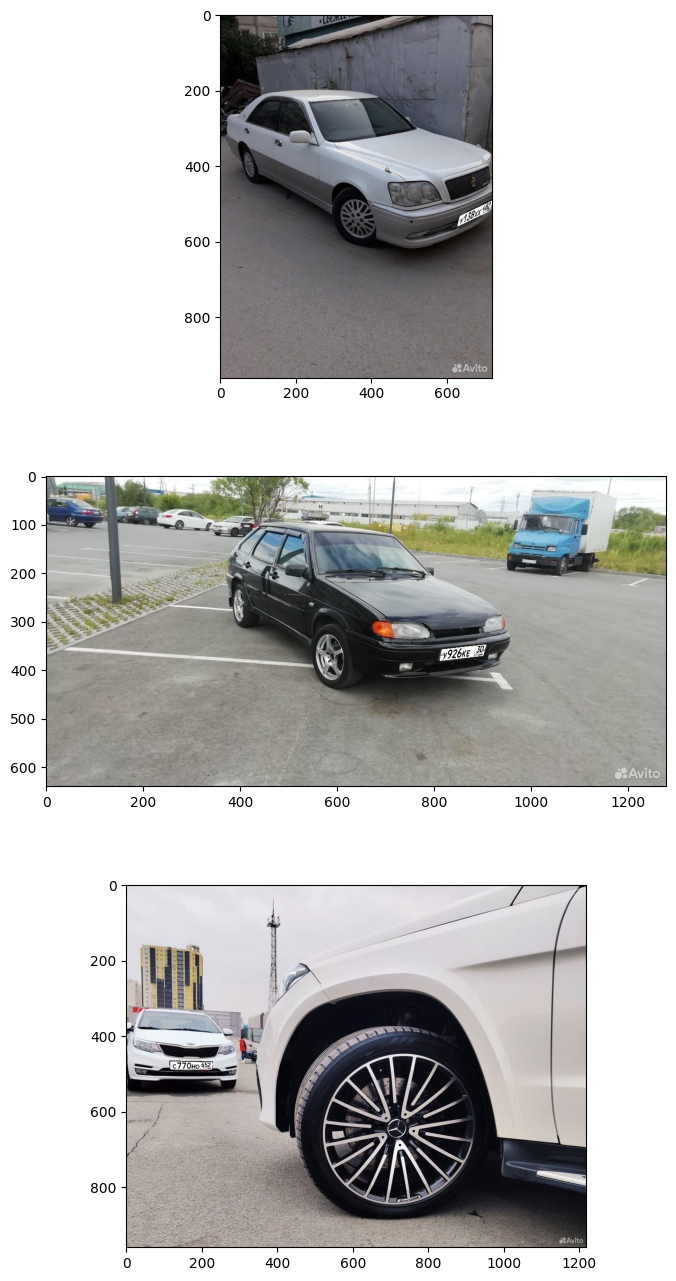

In [339]:
sample = random.sample(generated_basic, 3)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 16))
for i in range(3):
    axes[i].imshow(cv2.imread(sample[i], cv2.IMREAD_COLOR_RGB))

In [546]:
generated_hard = generate_images_with_plates(
    dataframe=df,
    plates_folder='/app/data/dataset/synt_plates_harder_10k',
    output_folder='/app/data/dataset/synt_cars_mud_blur_noise_3k',
    n=3000
)

Генерация изображений:  26%|██▌       | 773/3000 [00:10<00:31, 70.01it/s]

Пропуск изображения /app/data/dataset/images/12186653381.jpg, так как файл не существует.


Генерация изображений:  28%|██▊       | 831/3000 [00:11<00:30, 72.28it/s]

Пропуск изображения /app/data/dataset/images/11848631081.jpg, так как файл не существует.


Генерация изображений:  49%|████▊     | 1461/3000 [00:19<00:20, 76.38it/s]

Пропуск изображения /app/data/dataset/images/12345501417.jpg, так как файл не существует.


Генерация изображений:  57%|█████▋    | 1699/3000 [00:22<00:17, 72.34it/s]

Пропуск изображения /app/data/dataset/images/12004129050.jpg, так как файл не существует.


Генерация изображений:  67%|██████▋   | 2022/3000 [00:27<00:12, 78.54it/s]

Пропуск изображения /app/data/dataset/images/9670867025.jpg, так как файл не существует.


Генерация изображений: 100%|██████████| 3000/3000 [00:39<00:00, 75.15it/s]

Частичное искажение применено к 1465 изображений из 3000
Повышение контраста применено к 913 изображений из 3000
Масштабирование применено к 878 изображений из 3000
Пропущено 99 изображений из 3000 из-за плохого полигона


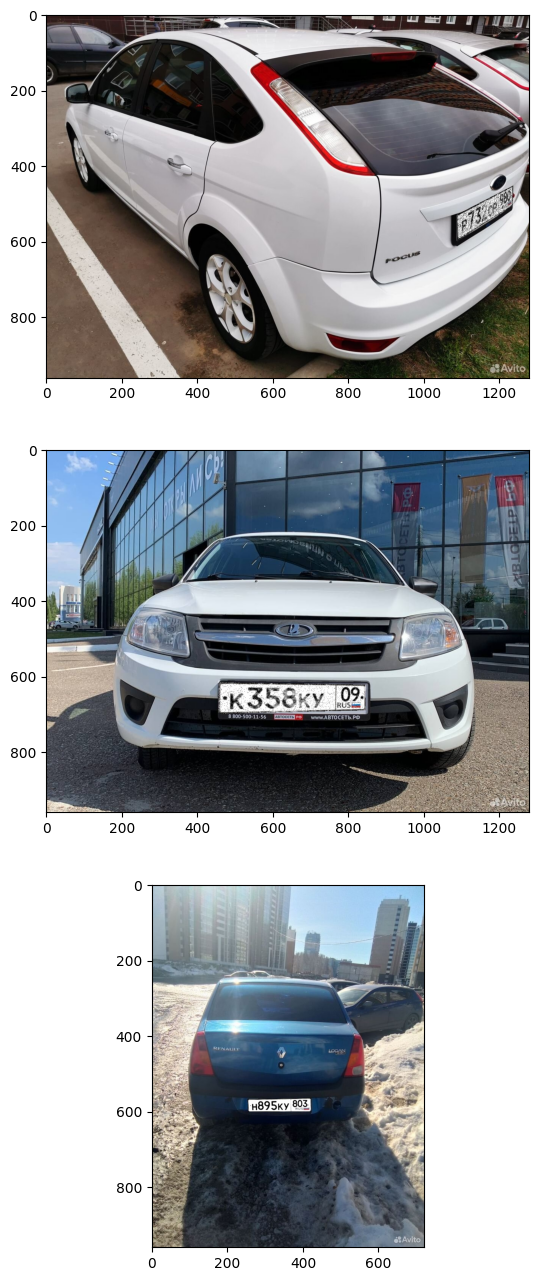

In [547]:
sample = random.sample(generated_hard, 3)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 16))
for i in range(3):
    axes[i].imshow(cv2.imread(sample[i], cv2.IMREAD_COLOR_RGB))

Подготовим данные для обучения. 

1. Возьмём 3000 картинок, которые не были задействованы в синтетике для обучения. 
2. Отрежем от синтетики 300 картинок для валидации на синтетике. В качестве примеров без фотошопа возьмём 300 случайных картинок из датасета.
3. Добавим к 43 реальным примерам фотошопа 100 примеров из датасета без фотошопа. Таким образом сформируем датасет с валидацией на реальных примерах.

В обучении будем использовать не всю картинку, а кроп ГРЗ с отсутопом 1.5.

In [548]:
columns = ['image_ext_id', 'image_path', 'platePolygon']
generated_basic_image_ids = [int(Path(i).stem) for i in generated_basic]
generated_hard_image_ids = [int(Path(i).stem) for i in generated_hard]

basic_synt_df = df[df.image_ext_id.isin(generated_basic_image_ids)].copy()[columns]
basic_synt_df.image_path = basic_synt_df.image_ext_id.apply(
    lambda x: Path('/app/data/dataset/synt_cars_basic_3k')/f'{x}.jpg')


hard_synt_df = df[df.image_ext_id.isin(generated_hard_image_ids)].copy()[columns]
hard_synt_df.image_path = hard_synt_df.image_ext_id.apply(
    lambda x: Path('/app/data/dataset/synt_cars_mud_blur_noise_3k')/f'{x}.jpg')

unused = df[~df.image_ext_id.isin(generated_basic_image_ids)][columns]
unused = unused[~unused.image_ext_id.isin(generated_hard_image_ids)][columns]

photoshoped_real = ph[columns].copy()
len(unused), len(df), len(basic_synt_df), len(hard_synt_df), len(photoshoped_real)

(36545, 42325, 3046, 2946, 43)

In [549]:
negative_sample = unused.sample(3400)

train_negative, val_test_negative = train_test_split(negative_sample, train_size=0.882)
val_negative, test_negative = train_test_split(val_test_negative, train_size=0.75)
train_simple_pos, val_simple_pos = train_test_split(basic_synt_df, train_size=0.9)
train_hard_pos, val_hard_pos = train_test_split(hard_synt_df, train_size=0.9)
len(train_negative), len(val_negative), len(test_negative), \
len(train_simple_pos), len(val_simple_pos), len(train_hard_pos), len(val_hard_pos)


(2998, 301, 101, 2741, 305, 2651, 295)

In [550]:
train_negative['target'] = 0
train_negative['fold'] = 'train'

val_negative['target'] = 0
val_negative['fold'] = 'val'

test_negative['target'] = 0
test_negative['fold'] = 'test'

train_simple_pos['target'] = 1
train_simple_pos['fold'] = 'train'

val_simple_pos['target'] = 1
val_simple_pos['fold'] = 'val'

train_hard_pos['target'] = 1
train_hard_pos['fold'] = 'train'

val_hard_pos['target'] = 1
val_hard_pos['fold'] = 'val'

photoshoped_real['target'] = 1
photoshoped_real['fold'] = 'test'



In [551]:
basic_df = pd.concat(
    [train_negative, train_simple_pos, val_simple_pos, val_negative, test_negative, photoshoped_real],
    ignore_index=True
)
hard_df = pd.concat(
    [train_negative, train_hard_pos, val_hard_pos, val_negative, test_negative, photoshoped_real],
    ignore_index=True
)

In [562]:
hard_dst = Path('/app/data/dataset/hard_ds')
hard_dst.mkdir(exist_ok=True, parents=True)
basic_dst = Path('/app/data/dataset/basic_ds')
basic_dst.mkdir(exist_ok=True, parents=True)

idx_to_drop_hard = []
for i, row in tqdm(hard_df.iterrows()):
    crop = crop_license_plate(row.image_path, row.platePolygon, alpha=1.5, output_size=(142, 660))
    if crop is None:
        idx_to_drop_hard.append(i)
        continue
    cv2.imwrite(str(hard_dst / f'{row.image_ext_id}.jpg'), crop)
    hard_df.loc[i, 'crop_path'] = str(hard_dst / f'{row.image_ext_id}.jpg')

idx_to_drop_basic = []
for i, row in tqdm(basic_df.iterrows()):
    crop = crop_license_plate(row.image_path, row.platePolygon, alpha=1.5, output_size=(142, 660))
    if crop is None:
        idx_to_drop_basic.append(i)
        continue
    cv2.imwrite(str(basic_dst / f'{row.image_ext_id}.jpg'), crop)
    basic_df.loc[i, 'crop_path'] = str(basic_dst / f'{row.image_ext_id}.jpg')

659it [00:04, 159.05it/s][ WARN:0@345816.925] global loadsave.cpp:268 findDecoder imread_('/app/data/dataset/images/11848631076.jpg'): can't open/read file: check file path/integrity
692it [00:04, 158.36it/s]

Не удалось открыть файл: /app/data/dataset/images/11848631076.jpg


1200it [00:07, 152.40it/s][ WARN:0@345820.358] global loadsave.cpp:268 findDecoder imread_('/app/data/dataset/images/12044633300.jpg'): can't open/read file: check file path/integrity
1217it [00:07, 155.63it/s]

Не удалось открыть файл: /app/data/dataset/images/12044633300.jpg


1612it [00:10, 151.97it/s][ WARN:0@345823.032] global loadsave.cpp:268 findDecoder imread_('/app/data/dataset/images/12201567569.jpg'): can't open/read file: check file path/integrity
1630it [00:10, 158.10it/s][ WARN:0@345823.152] global loadsave.cpp:268 findDecoder imread_('/app/data/dataset/images/11631580377.jpg'): can't open/read file: check file path/integrity
1647it [00:10, 160.52it/s]

Не удалось открыть файл: /app/data/dataset/images/12201567569.jpg
Не удалось открыть файл: /app/data/dataset/images/11631580377.jpg


1664it [00:10, 157.79it/s][ WARN:0@345823.353] global loadsave.cpp:268 findDecoder imread_('/app/data/dataset/images/12389449205.jpg'): can't open/read file: check file path/integrity
1698it [00:10, 161.30it/s]

Не удалось открыть файл: /app/data/dataset/images/12389449205.jpg


2051it [00:13, 157.66it/s][ WARN:0@345825.839] global loadsave.cpp:268 findDecoder imread_('/app/data/dataset/images/11848631080.jpg'): can't open/read file: check file path/integrity
2086it [00:13, 158.42it/s]

Не удалось открыть файл: /app/data/dataset/images/11848631080.jpg


6389it [00:44, 143.26it/s]
662it [00:04, 155.16it/s][ WARN:0@345861.502] global loadsave.cpp:268 findDecoder imread_('/app/data/dataset/images/11848631076.jpg'): can't open/read file: check file path/integrity
695it [00:04, 155.57it/s]

Не удалось открыть файл: /app/data/dataset/images/11848631076.jpg


1190it [00:07, 155.13it/s][ WARN:0@345864.894] global loadsave.cpp:268 findDecoder imread_('/app/data/dataset/images/12044633300.jpg'): can't open/read file: check file path/integrity
1223it [00:07, 157.11it/s]

Не удалось открыть файл: /app/data/dataset/images/12044633300.jpg


1603it [00:10, 155.54it/s][ WARN:0@345867.548] global loadsave.cpp:268 findDecoder imread_('/app/data/dataset/images/12201567569.jpg'): can't open/read file: check file path/integrity
1636it [00:10, 158.85it/s]

Не удалось открыть файл: /app/data/dataset/images/12201567569.jpg
Не удалось открыть файл: /app/data/dataset/images/11631580377.jpg


[ WARN:0@345867.669] global loadsave.cpp:268 findDecoder imread_('/app/data/dataset/images/11631580377.jpg'): can't open/read file: check file path/integrity
1653it [00:10, 160.82it/s][ WARN:0@345867.867] global loadsave.cpp:268 findDecoder imread_('/app/data/dataset/images/12389449205.jpg'): can't open/read file: check file path/integrity
1688it [00:10, 164.01it/s]

Не удалось открыть файл: /app/data/dataset/images/12389449205.jpg


2057it [00:13, 158.78it/s][ WARN:0@345870.350] global loadsave.cpp:268 findDecoder imread_('/app/data/dataset/images/11848631080.jpg'): can't open/read file: check file path/integrity
2092it [00:13, 160.04it/s]

Не удалось открыть файл: /app/data/dataset/images/11848631080.jpg


6489it [00:45, 142.45it/s]


In [563]:
hard_df.drop(idx_to_drop_hard, inplace=True)

In [564]:
basic_df.head(3)

image_ext_id                                image_path  \
0    8844664962   /app/data/dataset/images/8844664962.jpg   
1   11776392190  /app/data/dataset/images/11776392190.jpg   
2    9752758755   /app/data/dataset/images/9752758755.jpg   

                                        platePolygon  target   fold  \
0  [0.30469, 0.67041, 0.63281, 0.65186, 0.63411, ...       0  train   
1  [0.09999, 0.43421, 0.18385, 0.441, 0.18521, 0....       0  train   
2  [0.14941, 0.50377, 0.26569, 0.52956, 0.26614, ...       0  train   

                                    crop_path  
0   /app/data/dataset/basic_ds/8844664962.jpg  
1  /app/data/dataset/basic_ds/11776392190.jpg  
2   /app/data/dataset/basic_ds/9752758755.jpg

In [565]:
class PlateDataset(Dataset):
    def __init__(self, dataframe, fold, transform=None):
        self.dataframe = dataframe[dataframe['fold']==fold].copy().reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        crop = Image.open(self.dataframe.loc[idx, 'crop_path'])
        label = self.dataframe.loc[idx, 'target']
        if self.transform is not None:
            return self.transform(crop), torch.tensor(label, dtype=torch.float32)
        return crop, torch.tensor(label, dtype=torch.float32)

In [566]:
SIZE = (400,400)
transform = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [567]:
train_simple = PlateDataset(basic_df, 'train', transform)
val_simple = PlateDataset(basic_df, 'val', transform)
test_simple = PlateDataset(basic_df, 'test', transform)

train_hard = PlateDataset(hard_df, 'train', transform)
val_hard = PlateDataset(hard_df, 'val', transform)
test_hard = PlateDataset(hard_df, 'test', transform)

len(train_simple), len(val_simple), len(test_simple), \
len(train_hard), len(val_hard), len(test_hard)

(5739, 606, 144, 5550, 586, 141)

### 2.2. Обучим модель

In [568]:
class ResNetClassifier(nn.Module):
    def __init__(self):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet50(weights="ResNet50_Weights.DEFAULT")
        for param in self.resnet.parameters():
            param.requires_grad = False
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.resnet.fc.in_features, 1)
        )

    def forward(self, x):
        return self.resnet(x)

In [569]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Валидация"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).view(-1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = probs > 0.5
            all_labels.extend(labels.cpu().int().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)

    return val_loss / len(val_loader), accuracy, precision, recall, roc_auc


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    metrics_history = defaultdict(list)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        for images, labels in tqdm(train_loader, desc=f"Эпоха {epoch+1}/{epochs}"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images).view(-1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            all_labels.extend(labels.cpu().int().numpy())
            all_preds.extend(preds.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_precision = precision_score(all_labels, all_preds, zero_division=0)
        train_recall = recall_score(all_labels, all_preds)
        
        metrics_history['train_accuracy'].append(train_accuracy)
        metrics_history['train_precision'].append(train_precision)
        metrics_history['train_recall'].append(train_recall)
        
        val_loss, val_accuracy, val_precision, val_recall, val_roc_auc = \
            validate_model(model, val_loader, criterion, device)
        
        metrics_history['val_accuracy'].append(val_accuracy)
        metrics_history['val_precision'].append(val_precision)
        metrics_history['val_recall'].append(val_recall)
        metrics_history['val_roc_auc'].append(val_roc_auc)
        
        test_loss, test_accuracy, test_precision, test_recall, test_roc_auc = \
            validate_model(model, test_loader, criterion, device)
        
        metrics_history['test_accuracy'].append(test_accuracy)
        metrics_history['test_precision'].append(test_precision)
        metrics_history['test_recall'].append(test_recall)
        metrics_history['test_roc_auc'].append(test_roc_auc)
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_model.pth')

        if scheduler:
            scheduler.step()

        print(f"\nЭпоха [{epoch+1}/{epochs}]")
        print(f"Train Loss: {running_loss/len(train_loader):.4f}")
        print(f"Train - Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, ROC-AUC: {val_roc_auc:.4f}\n")
        print(f"Test   - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, ROC-AUC: {test_roc_auc:.4f}\n")

    model.load_state_dict(best_model_wts)
    return model, metrics_history

Эксперимент с базовой синтетикой

In [462]:
train_loader = DataLoader(train_simple, batch_size=128, shuffle=True)
val_loader = DataLoader(val_simple, batch_size=64, shuffle=True)
test_loader = DataLoader(test_simple, batch_size=64, shuffle=True)

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

model = ResNetClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model, metrics_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=10
)

torch.save(model.state_dict(), "/app/data/model_basic.pt")

Используемое устройство: cuda:2


Валидация: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]



Эпоха [1/10]
Train Loss: 0.2269
Train - Accuracy: 0.9554, Precision: 0.9666, Recall: 0.9391
Val   - Loss: 0.0213, Accuracy: 0.9983, Precision: 0.9967, Recall: 1.0000, ROC-AUC: 0.9998

Test   - Loss: 1.0776, Accuracy: 0.7778, Precision: 1.0000, Recall: 0.2558, ROC-AUC: 0.6178



Валидация: 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]



Эпоха [2/10]
Train Loss: 0.0100
Train - Accuracy: 0.9984, Precision: 0.9975, Recall: 0.9993
Val   - Loss: 0.0076, Accuracy: 0.9983, Precision: 0.9967, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 1.3036, Accuracy: 0.7431, Precision: 0.8750, Recall: 0.1628, ROC-AUC: 0.7267



Валидация: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]



Эпоха [3/10]
Train Loss: 0.0055
Train - Accuracy: 0.9984, Precision: 0.9982, Recall: 0.9985
Val   - Loss: 0.0067, Accuracy: 0.9983, Precision: 0.9967, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 1.2763, Accuracy: 0.7431, Precision: 1.0000, Recall: 0.1395, ROC-AUC: 0.7746



Валидация: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]



Эпоха [4/10]
Train Loss: 0.0026
Train - Accuracy: 0.9998, Precision: 0.9996, Recall: 1.0000
Val   - Loss: 0.0062, Accuracy: 0.9983, Precision: 0.9967, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 1.5487, Accuracy: 0.7292, Precision: 1.0000, Recall: 0.0930, ROC-AUC: 0.6871



Валидация: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]



Эпоха [5/10]
Train Loss: 0.0025
Train - Accuracy: 0.9995, Precision: 0.9993, Recall: 0.9996
Val   - Loss: 0.0046, Accuracy: 0.9983, Precision: 0.9967, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 1.6853, Accuracy: 0.7222, Precision: 1.0000, Recall: 0.0698, ROC-AUC: 0.7564



Валидация: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]



Эпоха [6/10]
Train Loss: 0.0043
Train - Accuracy: 0.9991, Precision: 0.9985, Recall: 0.9996
Val   - Loss: 0.0020, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 2.2361, Accuracy: 0.7014, Precision: 0.0000, Recall: 0.0000, ROC-AUC: 0.7400



Валидация: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]



Эпоха [7/10]
Train Loss: 0.0010
Train - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000
Val   - Loss: 0.0007, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 2.0300, Accuracy: 0.7361, Precision: 1.0000, Recall: 0.1163, ROC-AUC: 0.7396



Валидация: 100%|██████████| 3/3 [00:00<00:00,  3.98it/s]



Эпоха [8/10]
Train Loss: 0.0006
Train - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000
Val   - Loss: 0.0009, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 2.0136, Accuracy: 0.7222, Precision: 1.0000, Recall: 0.0698, ROC-AUC: 0.7516



Валидация: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]



Эпоха [9/10]
Train Loss: 0.0007
Train - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000
Val   - Loss: 0.0017, Accuracy: 0.9983, Precision: 0.9967, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 1.7604, Accuracy: 0.7222, Precision: 1.0000, Recall: 0.0698, ROC-AUC: 0.7184



Валидация: 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]



Эпоха [10/10]
Train Loss: 0.0009
Train - Accuracy: 0.9998, Precision: 0.9996, Recall: 1.0000
Val   - Loss: 0.0041, Accuracy: 0.9983, Precision: 1.0000, Recall: 0.9967, ROC-AUC: 1.0000

Test   - Loss: 1.8239, Accuracy: 0.7083, Precision: 1.0000, Recall: 0.0233, ROC-AUC: 0.7145



In [572]:
def plot_metrics(h):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
    axes[0].plot(h['train_accuracy'], label='train')
    axes[0].plot(h['val_accuracy'], label='val')
    axes[0].plot(h['test_accuracy'], label='test')
    axes[0].set_title('Accuracy')
    
    axes[1].plot(h['train_precision'], label='train')
    axes[1].plot(h['val_precision'], label='val')
    axes[1].plot(h['test_precision'], label='test')
    axes[1].set_title('Precision')
    
    axes[2].plot(h['train_recall'], label='train')
    axes[2].plot(h['val_recall'], label='val')
    axes[2].plot(h['test_recall'], label='test')
    axes[2].set_title('Recall')
    plt.show()

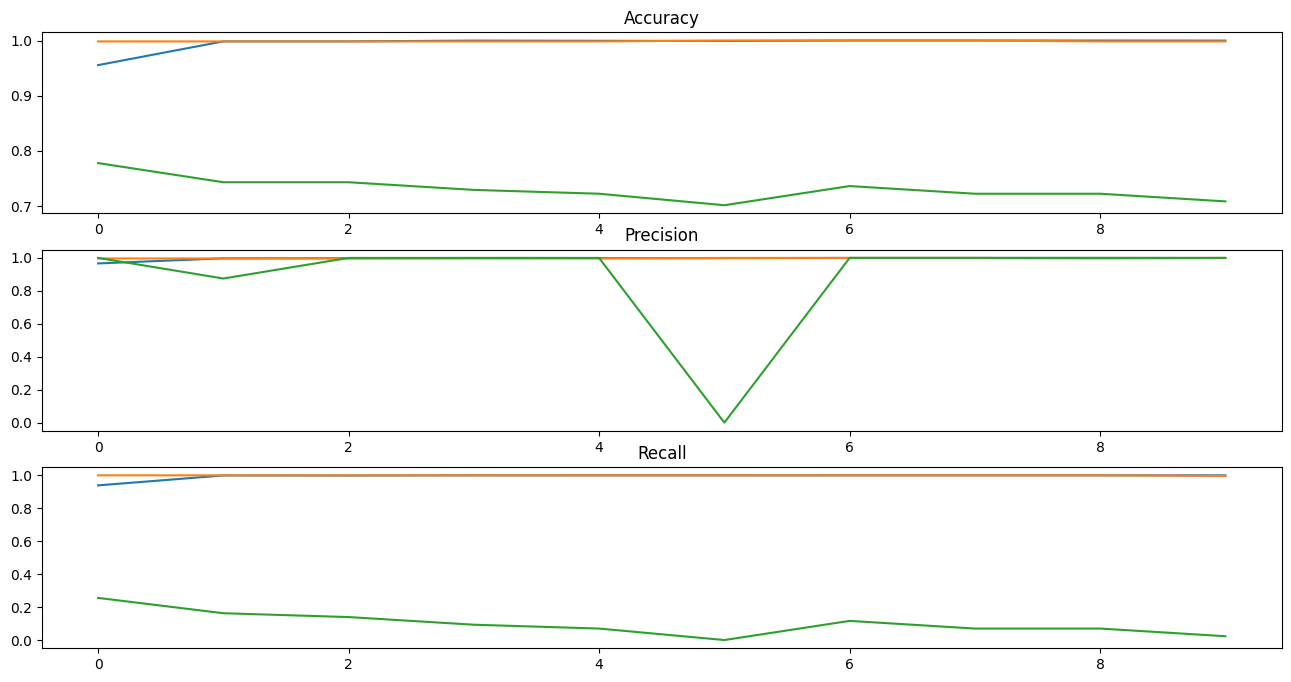

In [466]:
plot_metrics(metrics_history)

Эксперимент с прдвинутой синтетикой

In [570]:
train_loader = DataLoader(train_hard, batch_size=128, shuffle=True)
val_loader = DataLoader(val_hard, batch_size=64, shuffle=True)
test_loader = DataLoader(test_hard, batch_size=64, shuffle=True)

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

model = ResNetClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model, metrics_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=10
)

torch.save(model.state_dict(), "/app/data/model_hard_with_organic.pt")

Используемое устройство: cuda:2


Валидация: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]



Эпоха [1/10]
Train Loss: 0.3112
Train - Accuracy: 0.9202, Precision: 0.8937, Recall: 0.9453
Val   - Loss: 0.0360, Accuracy: 0.9915, Precision: 1.0000, Recall: 0.9831, ROC-AUC: 0.9999

Test   - Loss: 0.9257, Accuracy: 0.8014, Precision: 0.9412, Recall: 0.3721, ROC-AUC: 0.6822



Валидация: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]



Эпоха [2/10]
Train Loss: 0.0216
Train - Accuracy: 0.9955, Precision: 0.9955, Recall: 0.9951
Val   - Loss: 0.0101, Accuracy: 0.9966, Precision: 0.9966, Recall: 0.9966, ROC-AUC: 1.0000

Test   - Loss: 0.9543, Accuracy: 0.8085, Precision: 0.9444, Recall: 0.3953, ROC-AUC: 0.7596



Валидация: 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]



Эпоха [3/10]
Train Loss: 0.0114
Train - Accuracy: 0.9975, Precision: 0.9966, Recall: 0.9981
Val   - Loss: 0.0095, Accuracy: 0.9966, Precision: 0.9933, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 0.8300, Accuracy: 0.7872, Precision: 0.8095, Recall: 0.3953, ROC-AUC: 0.7831



Валидация: 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]



Эпоха [4/10]
Train Loss: 0.0068
Train - Accuracy: 0.9987, Precision: 0.9985, Recall: 0.9989
Val   - Loss: 0.0030, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 1.0215, Accuracy: 0.7801, Precision: 0.8750, Recall: 0.3256, ROC-AUC: 0.8329



Валидация: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]



Эпоха [5/10]
Train Loss: 0.0046
Train - Accuracy: 0.9989, Precision: 0.9985, Recall: 0.9992
Val   - Loss: 0.0036, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 0.9557, Accuracy: 0.7872, Precision: 0.9333, Recall: 0.3256, ROC-AUC: 0.7565



Валидация: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]



Эпоха [6/10]
Train Loss: 0.0032
Train - Accuracy: 0.9995, Precision: 1.0000, Recall: 0.9989
Val   - Loss: 0.0021, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 1.4878, Accuracy: 0.7730, Precision: 0.9231, Recall: 0.2791, ROC-AUC: 0.7810



Валидация: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]



Эпоха [7/10]
Train Loss: 0.0067
Train - Accuracy: 0.9984, Precision: 0.9981, Recall: 0.9985
Val   - Loss: 0.0022, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 1.1820, Accuracy: 0.7730, Precision: 1.0000, Recall: 0.2558, ROC-AUC: 0.8536



Валидация: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]



Эпоха [8/10]
Train Loss: 0.0031
Train - Accuracy: 0.9995, Precision: 0.9996, Recall: 0.9992
Val   - Loss: 0.0019, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 1.5786, Accuracy: 0.8014, Precision: 1.0000, Recall: 0.3488, ROC-AUC: 0.8166



Валидация: 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]



Эпоха [9/10]
Train Loss: 0.0025
Train - Accuracy: 0.9998, Precision: 1.0000, Recall: 0.9996
Val   - Loss: 0.0018, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 1.0683, Accuracy: 0.7943, Precision: 0.9375, Recall: 0.3488, ROC-AUC: 0.7926



Валидация: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]



Эпоха [10/10]
Train Loss: 0.0022
Train - Accuracy: 0.9998, Precision: 1.0000, Recall: 0.9996
Val   - Loss: 0.0041, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, ROC-AUC: 1.0000

Test   - Loss: 1.1166, Accuracy: 0.7730, Precision: 1.0000, Recall: 0.2558, ROC-AUC: 0.8367



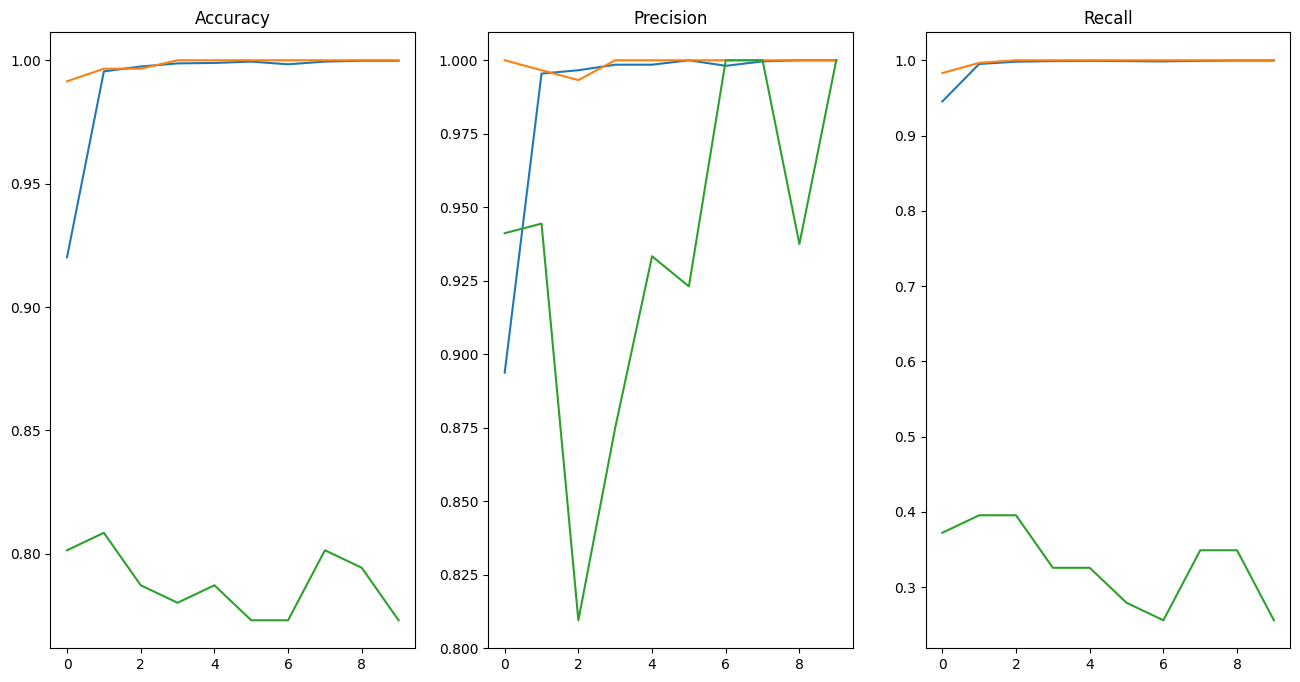

In [573]:
plot_metrics(metrics_history)